## Withdrawal Network - Threshold Low

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import bct as bct
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Prepare the network for analysis.

Load the withdrawal correlation matrix.

In [2]:
withdrawal_df = pd.read_csv('../../data/cFosCAN_alcohol_withdrawal_orig_20180326.csv')

Set the index to the region labels.

In [3]:
withdrawal_df = withdrawal_df.set_index('Unnamed: 0')

Sort regions alphabetically.

In [4]:
withdrawal_df = withdrawal_df.sort_index()
withdrawal_df = withdrawal_df.sort_index(axis=1)

In [5]:
withdrawal_mat = withdrawal_df.as_matrix()

Zero-out the diagonal and edges with r<|0.75|, then save the matrix for analysis in MATLAB.

In [7]:
np.fill_diagonal(withdrawal_mat, 0)

In [8]:
withdrawal_mat_thresh = withdrawal_mat.copy()

In [9]:
pos_mask = (withdrawal_mat_thresh >= 0.75)

In [10]:
neg_mask = (withdrawal_mat_thresh <= -0.75)

In [11]:
mask = pos_mask + neg_mask

In [12]:
withdrawal_mat_thresh[~mask] = 0

Createa a data frame for the thresholded matrix.

In [13]:
withdrawal_mat_thresh_df = pd.DataFrame(withdrawal_mat_thresh)

Add column and index labels back in.

In [14]:
withdrawal_mat_thresh_df.columns = withdrawal_df.columns[:]

In [15]:
withdrawal_mat_thresh_df.index = withdrawal_df.index

Drop regions that have been disconnected during thresholding

In [16]:
disconnected_regions = (withdrawal_mat_thresh_df != 0).any(axis=0)

In [17]:
withdrawal_mat_cc_df = withdrawal_mat_thresh_df.loc[disconnected_regions,disconnected_regions]

Save the connected component of the network as a matrix.

In [18]:
np.savetxt('../../data/cFosCAN_alcohol_withdrawal_mat_thresh075_CC_20180526.csv', withdrawal_mat_cc_df.as_matrix(), delimiter=' ')

Create a network with only positive edges for use during plotting.

In [19]:
withdrawal_mat_cc_po = withdrawal_mat_cc_df.as_matrix().copy()

In [20]:
withdrawal_mat_cc_po[withdrawal_mat_cc_po < 0] = 0

In [21]:
G_thresh = nx.from_numpy_matrix(withdrawal_mat_cc_po)

#### Centrality (node strength)

In [22]:
node_strength = bct.degree.strengths_und_sign(withdrawal_mat_cc_df.as_matrix())

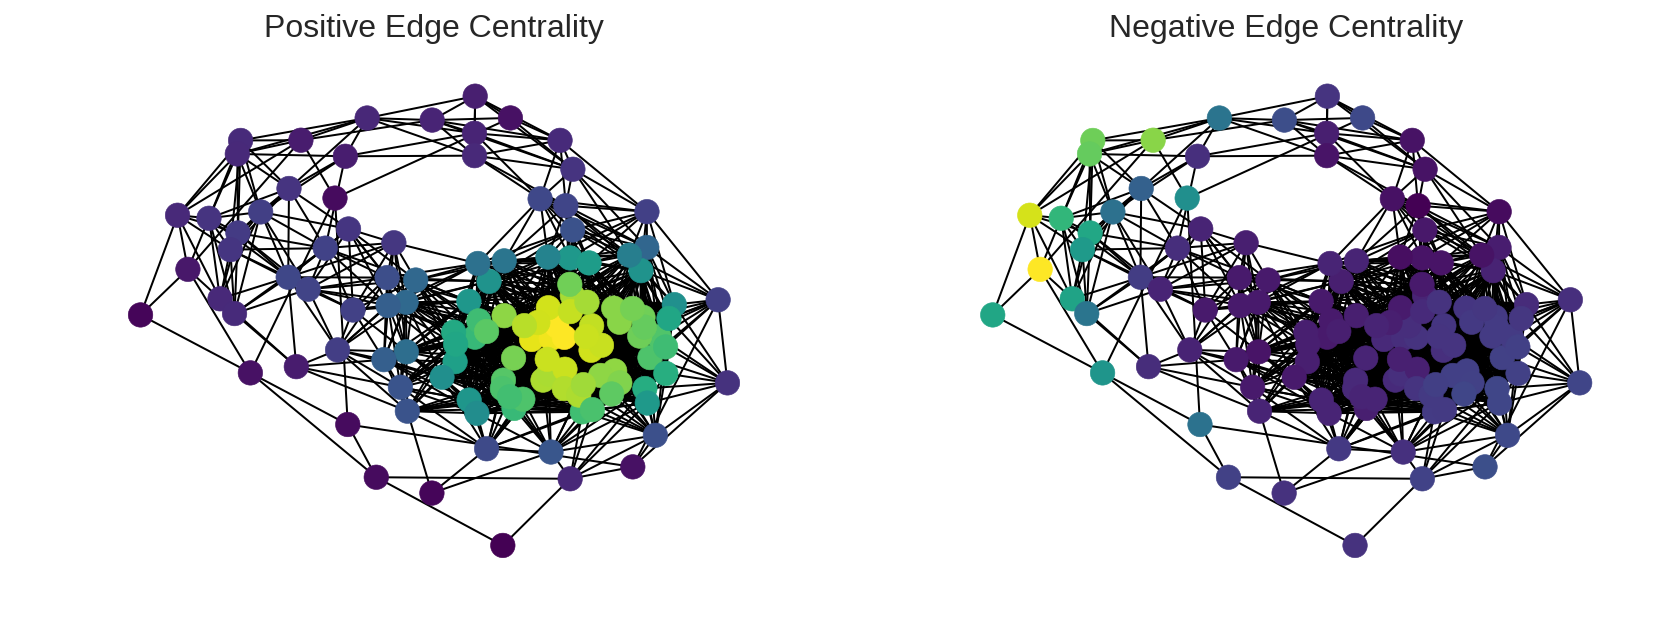

In [23]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
g = nx.draw_kamada_kawai(G_thresh, node_color=node_strength[0], node_size=150, cmap=plt.cm.viridis, ax=ax[0])
g = nx.draw_kamada_kawai(G_thresh, node_color=node_strength[1], node_size=150, cmap=plt.cm.viridis_r, ax=ax[1])
g = ax[0].set_title('Positive Edge Centrality', fontsize=16)
g = ax[1].set_title('Negative Edge Centrality', fontsize=16)

### Visualize the thresholded Louvain partition and nodal metrics.
These were calculated using the `network_analysis_nothresh.py` script.

In [24]:
reordered_matrix = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_ReorderedMatrix.txt')

In [25]:
reordered_matrix = reordered_matrix.reshape(withdrawal_mat_cc_df.as_matrix().shape)

In [26]:
partition = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_GraphPartition.txt')

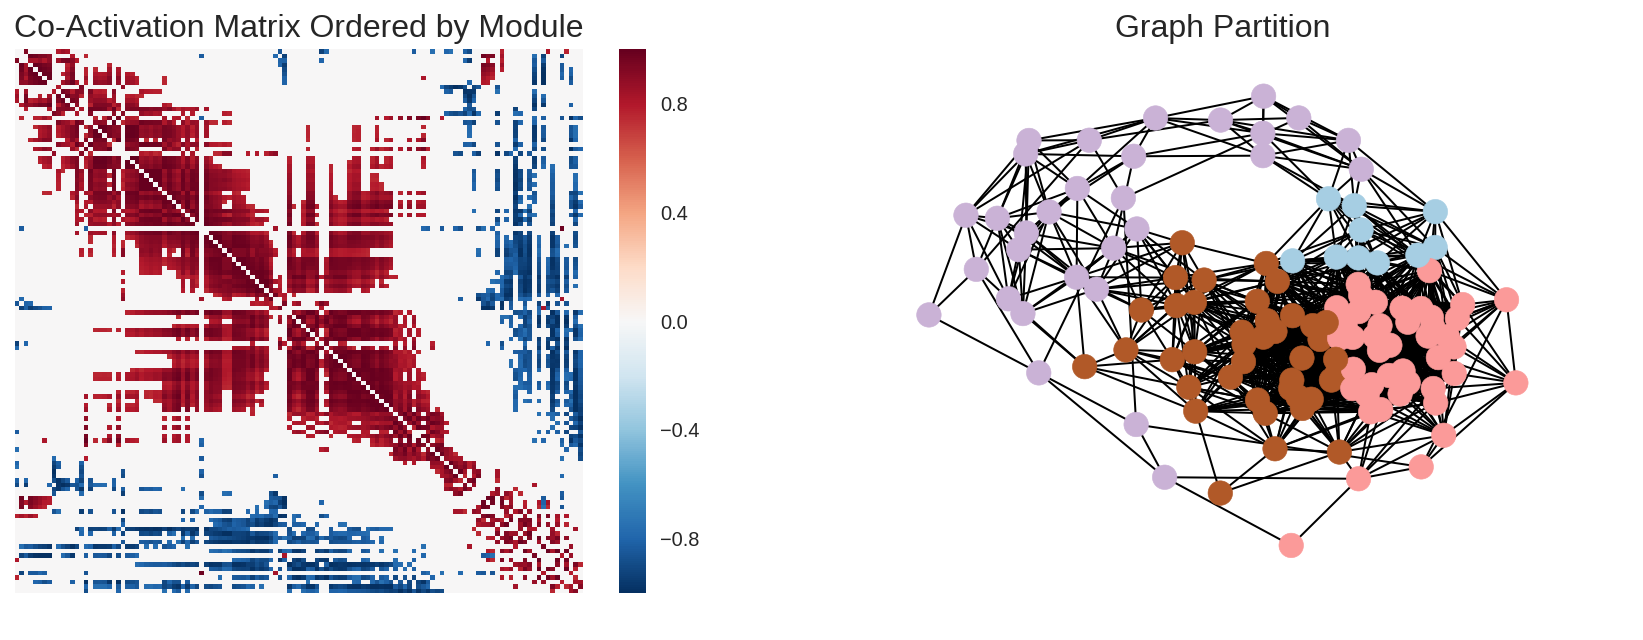

In [27]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
g = sns.heatmap(reordered_matrix, xticklabels=False, yticklabels=False, ax=ax[0], )
g = nx.draw_kamada_kawai(G_thresh, node_color=partition, node_size=150, cmap=plt.cm.Paired, ax=ax[1])
g = ax[0].set_title('Co-Activation Matrix Ordered by Module', fontsize=16)
g = ax[1].set_title('Graph Partition', fontsize=16)

#### Within-Module Degree (z-scored)

In [28]:
wmdz_pos = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_WMDz_pos.txt')

In [29]:
wmdz_neg = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_WMDz_neg.txt')

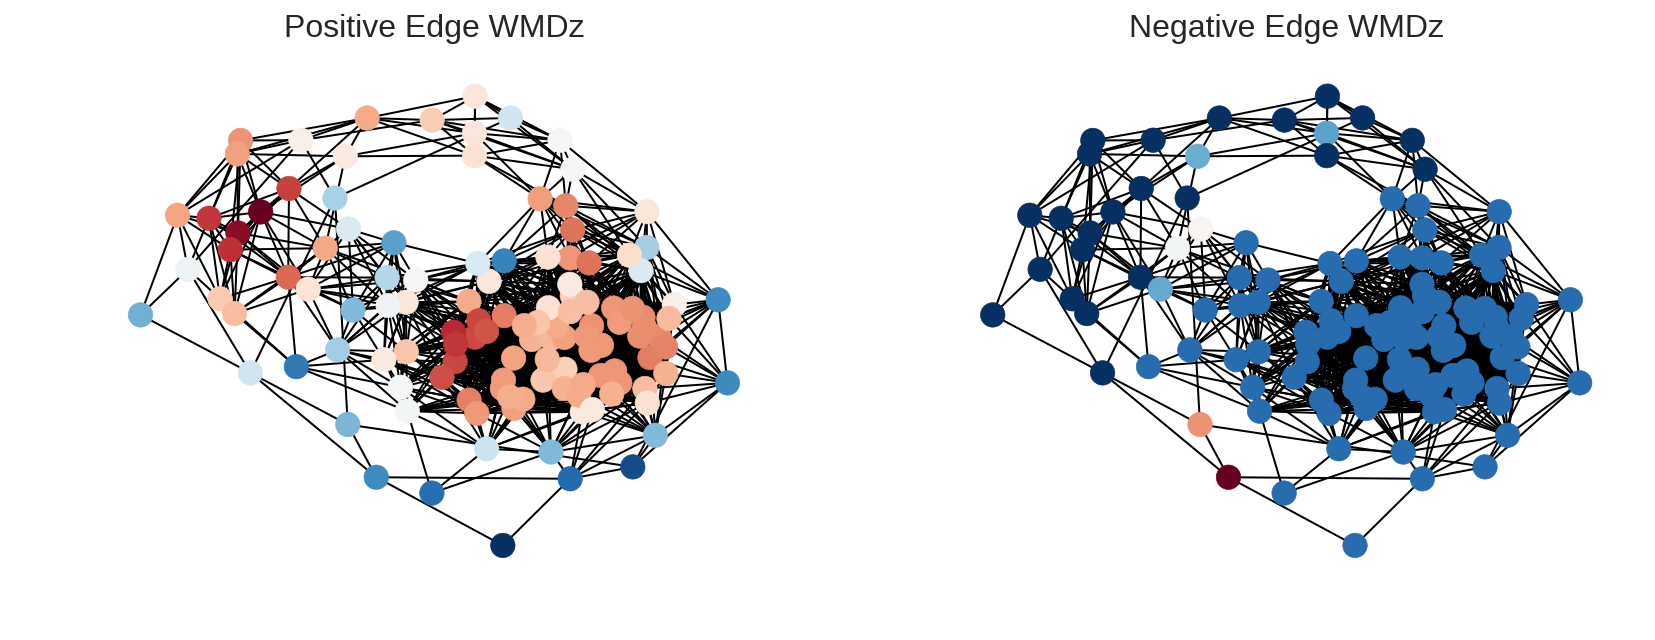

In [30]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_pos, node_size=150, cmap=plt.cm.RdBu_r, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_neg, node_size=150, cmap=plt.cm.RdBu, ax=ax[1])
g = ax[0].set_title('Positive Edge WMDz', fontsize=16)
g = ax[1].set_title('Negative Edge WMDz', fontsize=16)

#### Participation Coefficient

In [31]:
pc_pos = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_PC_pos.txt')

In [32]:
pc_neg = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_PC_neg.txt')

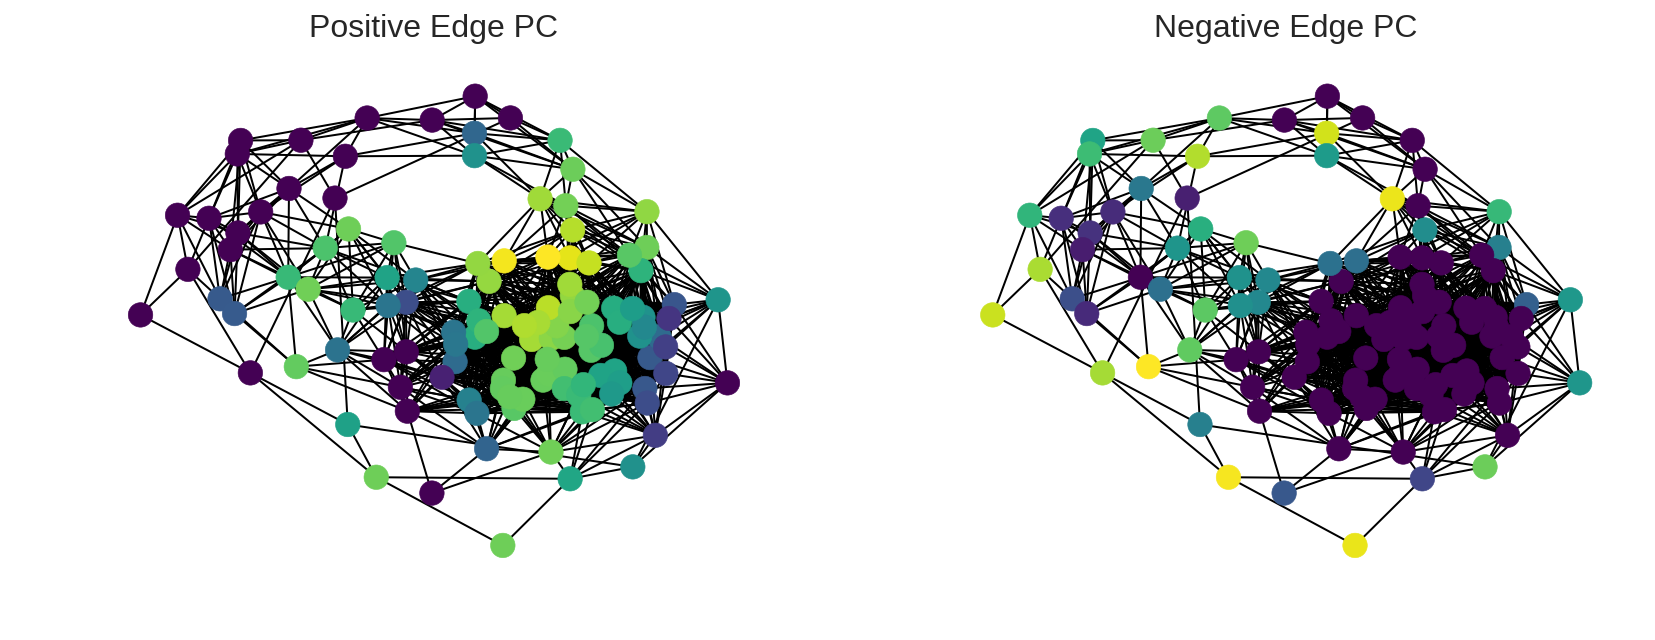

In [33]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=pc_pos, node_size=150, cmap=plt.cm.viridis, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=pc_neg, node_size=150, cmap=plt.cm.viridis, ax=ax[1])
g = ax[0].set_title('Positive Edge PC', fontsize=16)
g = ax[1].set_title('Negative Edge PC', fontsize=16)

Combine all our results into a single spreadsheet.

In [34]:
combined_df = pd.DataFrame(np.array([node_strength[0], node_strength[1], partition, pc_pos, pc_neg, wmdz_pos, wmdz_neg]).T,
                           columns=['centrality_pos', 'centrality_neg', 'partition', 'pc_pos', 'pc_neg', 'wmdz_pos', 'wmdz_neg'])

In [35]:
combined_df = combined_df.set_index(withdrawal_mat_cc_df.index)

In [36]:
combined_df.index.names = ['Region']

Save the combined spreadsheet to disk.

In [37]:
combined_df.to_csv('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/gamma1.0_combined_results.csv', sep=',')

### Impose the unthresholded Louvain partition and calculate nodal metrics.

In [38]:
partition_nothresh = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_nothresh/gamma1.0_GraphPartition.txt')

In [39]:
partition_nothresh_df = pd.DataFrame(partition_nothresh, index=withdrawal_df.index)

In [40]:
partition_nothresh_df.index.names=['Region']

Get an array containing module assignments for nodes in the connected component.

In [41]:
partition_nothresh_cc = partition_nothresh_df.iloc[disconnected_regions.values,0].values

Draw the graph with nodes colored by module.

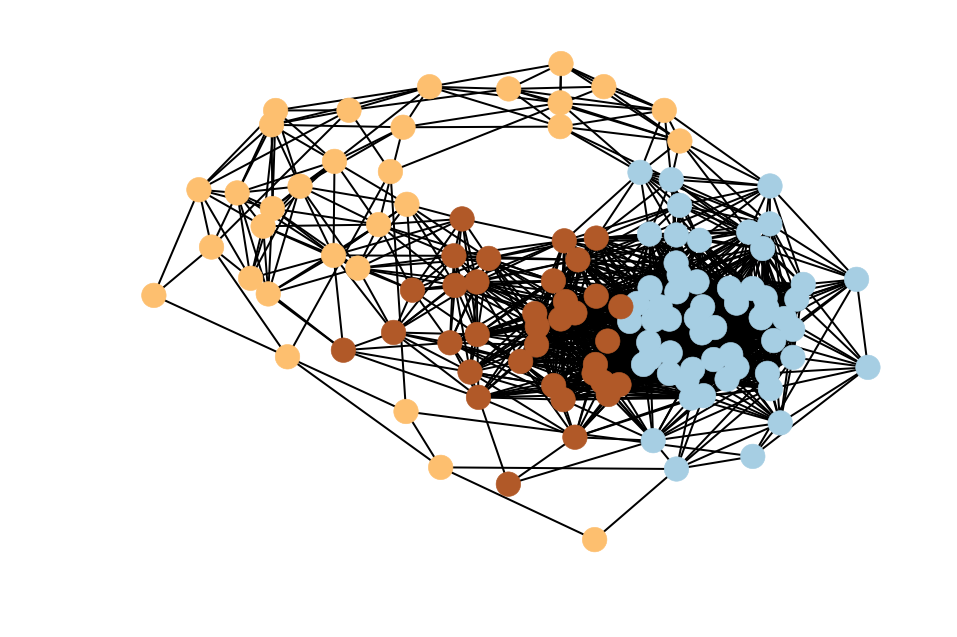

In [42]:
nx.draw_kamada_kawai(G_thresh, node_color=partition_nothresh_cc, node_size=150, cmap=plt.cm.Paired)

#### Participation Coefficient

In [43]:
pc_nothresh = bct.centrality.participation_coef_sign(withdrawal_mat_cc_df.as_matrix(), partition_nothresh_cc)

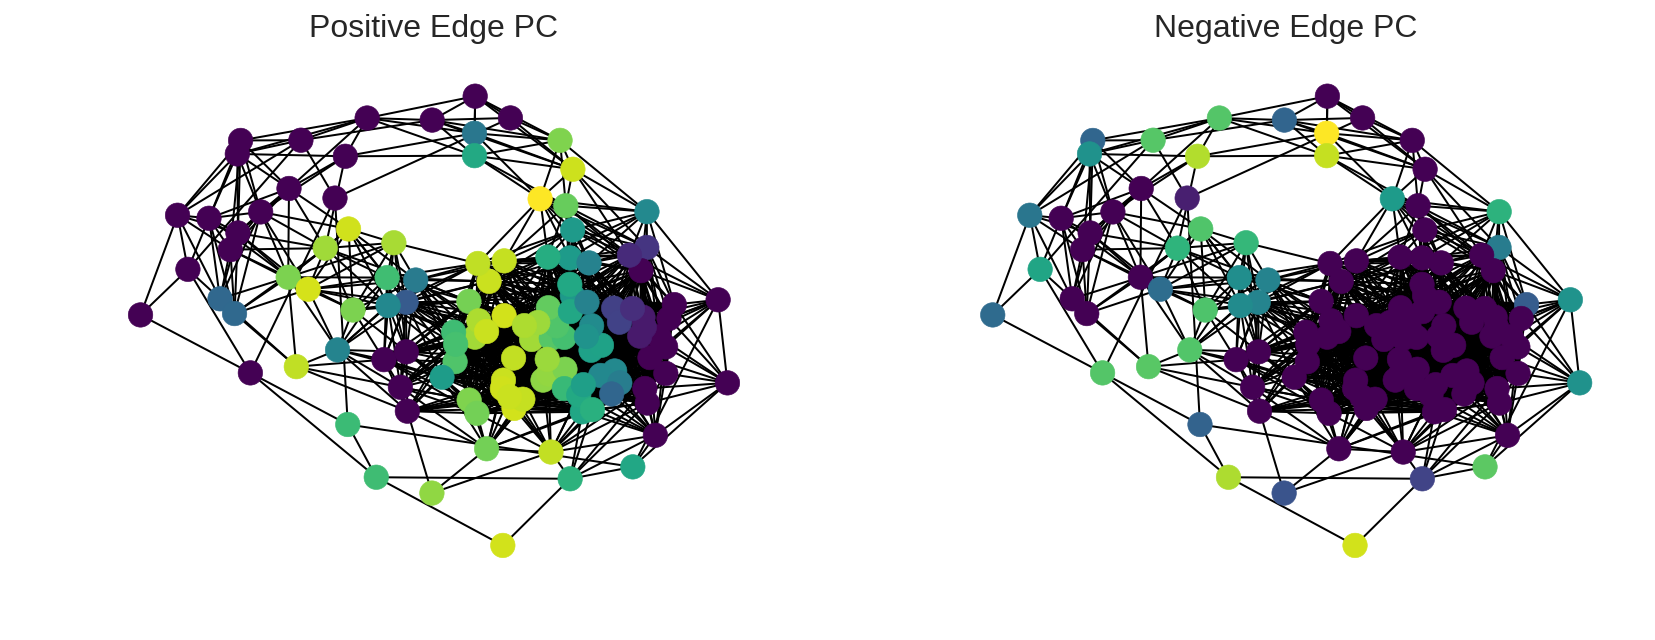

In [44]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=pc_nothresh[0], node_size=150, cmap=plt.cm.viridis, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=pc_nothresh[1], node_size=150, cmap=plt.cm.viridis, ax=ax[1])
g = ax[0].set_title('Positive Edge PC', fontsize=16)
g = ax[1].set_title('Negative Edge PC', fontsize=16)

#### Within-Module Degree (z-scored)

In [45]:
wmdz_nothresh = bct.centrality.module_degree_zscore_sign(withdrawal_mat_cc_df.as_matrix(), partition_nothresh_cc)

/home/despoB/dlurie/Software/bctpy/bct/algorithms/centrality.py:698: RuntimeWarning: invalid value encountered in true_divide
  Z_neg[np.where(ci == i)] = (Koi_neg - np.mean(Koi_neg)) / np.std(Koi_neg)


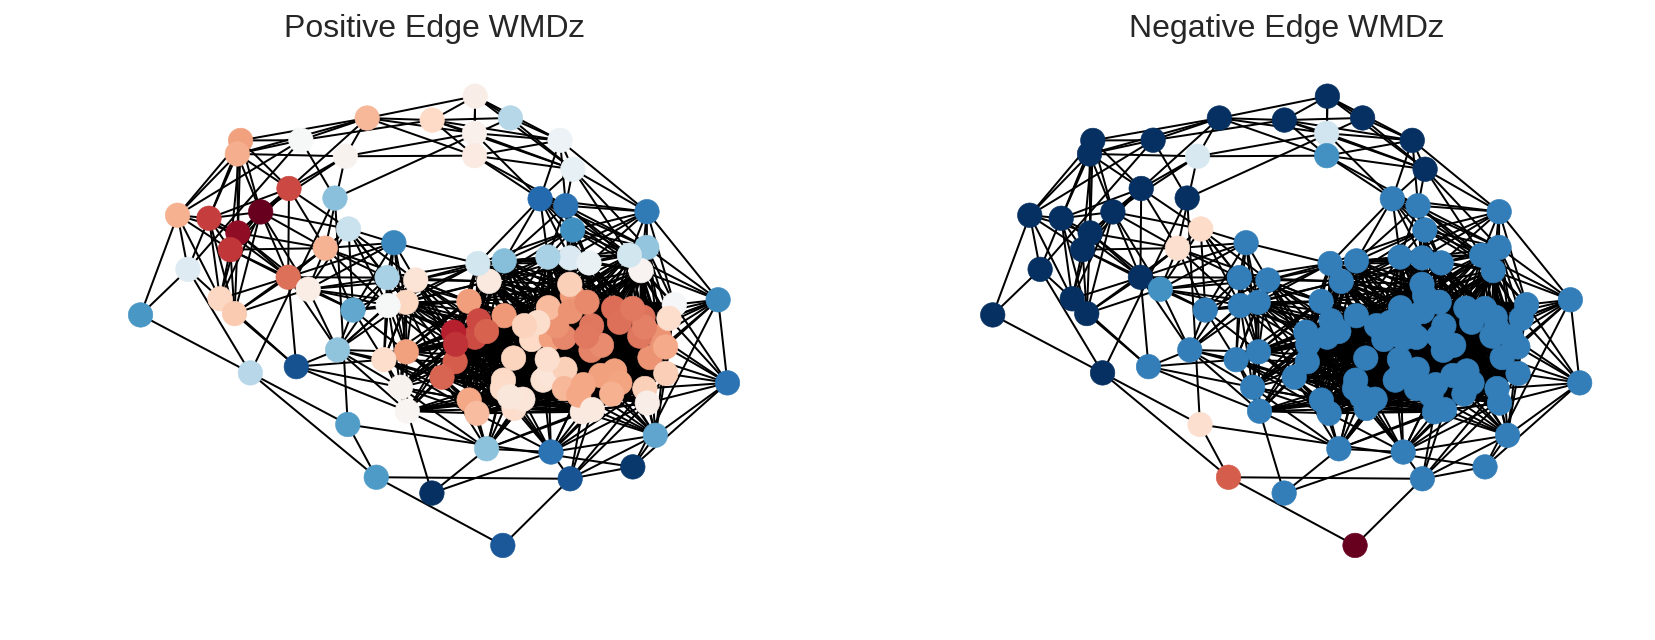

In [46]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_nothresh[1], node_size=150, cmap=plt.cm.RdBu_r, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_nothresh[2], node_size=150, cmap=plt.cm.RdBu, ax=ax[1])
g = ax[0].set_title('Positive Edge WMDz', fontsize=16)
g = ax[1].set_title('Negative Edge WMDz', fontsize=16)

Combine all our results into a single spreadsheet.

In [47]:
combined_df = pd.DataFrame(np.array([node_strength[0], node_strength[0], partition_nothresh_cc, pc_nothresh[0], pc_nothresh[1], wmdz_nothresh[1], wmdz_nothresh[2]]).T,
                           columns=['centrality_pos', 'centrality_neg', 'partition', 'pc_pos', 'pc_neg', 'wmdz_pos', 'wmdz_neg'])

In [48]:
combined_df = combined_df.set_index(withdrawal_mat_cc_df.index)

In [49]:
combined_df.index.names = ['Region']

Save the combined spreadsheet to disk.

In [50]:
combined_df.to_csv('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/NothreshPartition_combined_results.csv', sep=',')

### Impose the HAC partition and calculate nodal metrics.

In [51]:
partition_hac_df = pd.read_csv('/home/despoB/dlurie/Projects/withdrawal_CAN/data/CIEHierarchicalClusteringPartition.csv', index_col='Region')

In [52]:
partition_hac_df = partition_hac_df.sort_index()

Get an array containing module assignments for nodes in the connected component.

In [53]:
partition_hac_cc = partition_hac_df.iloc[disconnected_regions.values,0].values

Draw the graph with nodes colored by module.

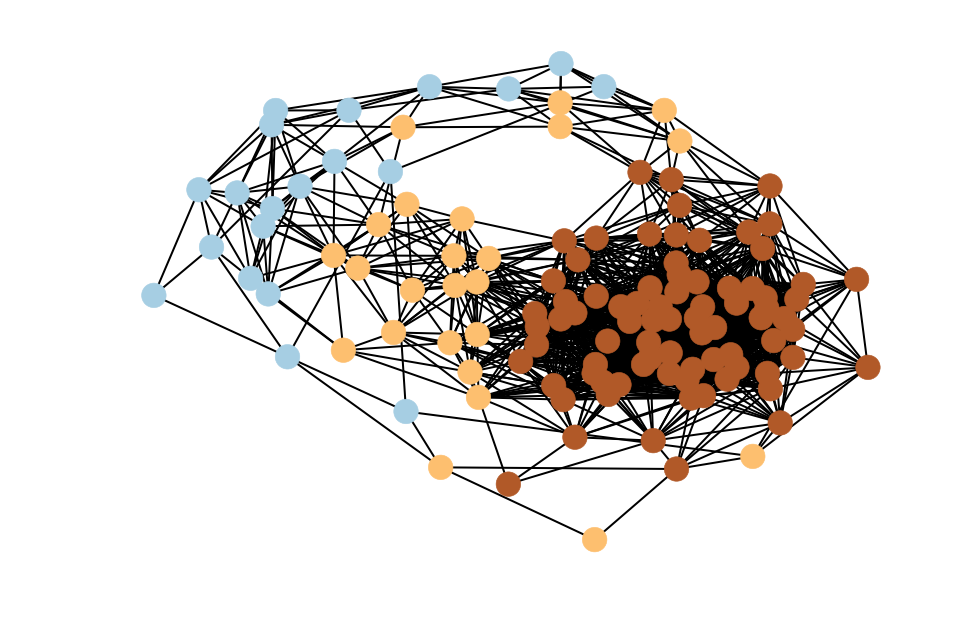

In [54]:
nx.draw_kamada_kawai(G_thresh, node_color=partition_hac_cc, node_size=150, cmap=plt.cm.Paired)

#### Participation Coefficient

In [55]:
pc_hac = bct.centrality.participation_coef_sign(withdrawal_mat_cc_df.as_matrix(), partition_hac_cc)

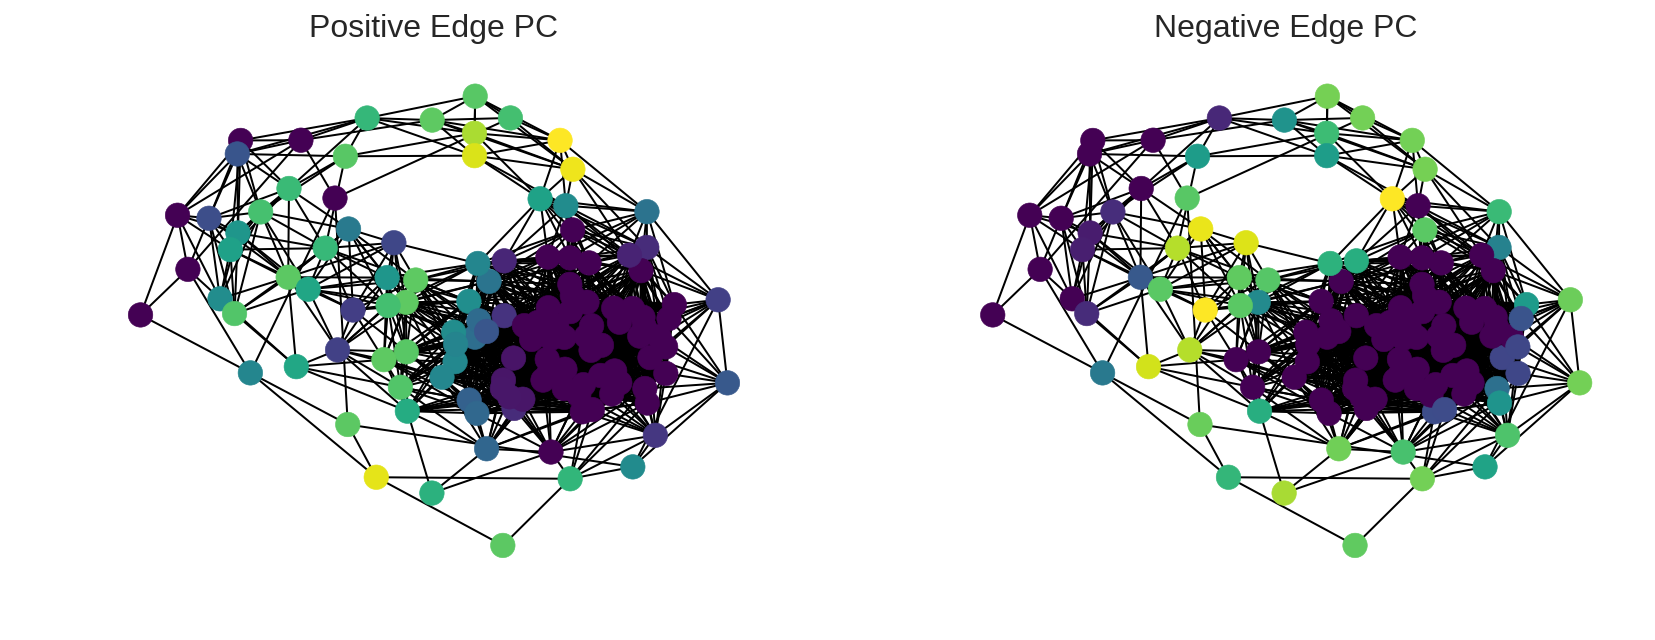

In [56]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=pc_hac[0], node_size=150, cmap=plt.cm.viridis, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=pc_hac[1], node_size=150, cmap=plt.cm.viridis, ax=ax[1])
g = ax[0].set_title('Positive Edge PC', fontsize=16)
g = ax[1].set_title('Negative Edge PC', fontsize=16)

#### Within-Module Degree (z-scored)

In [57]:
wmdz_hac = bct.centrality.module_degree_zscore_sign(withdrawal_mat_cc_df.as_matrix(), partition_hac_cc)

/home/despoB/dlurie/Software/bctpy/bct/algorithms/centrality.py:698: RuntimeWarning: invalid value encountered in true_divide
  Z_neg[np.where(ci == i)] = (Koi_neg - np.mean(Koi_neg)) / np.std(Koi_neg)


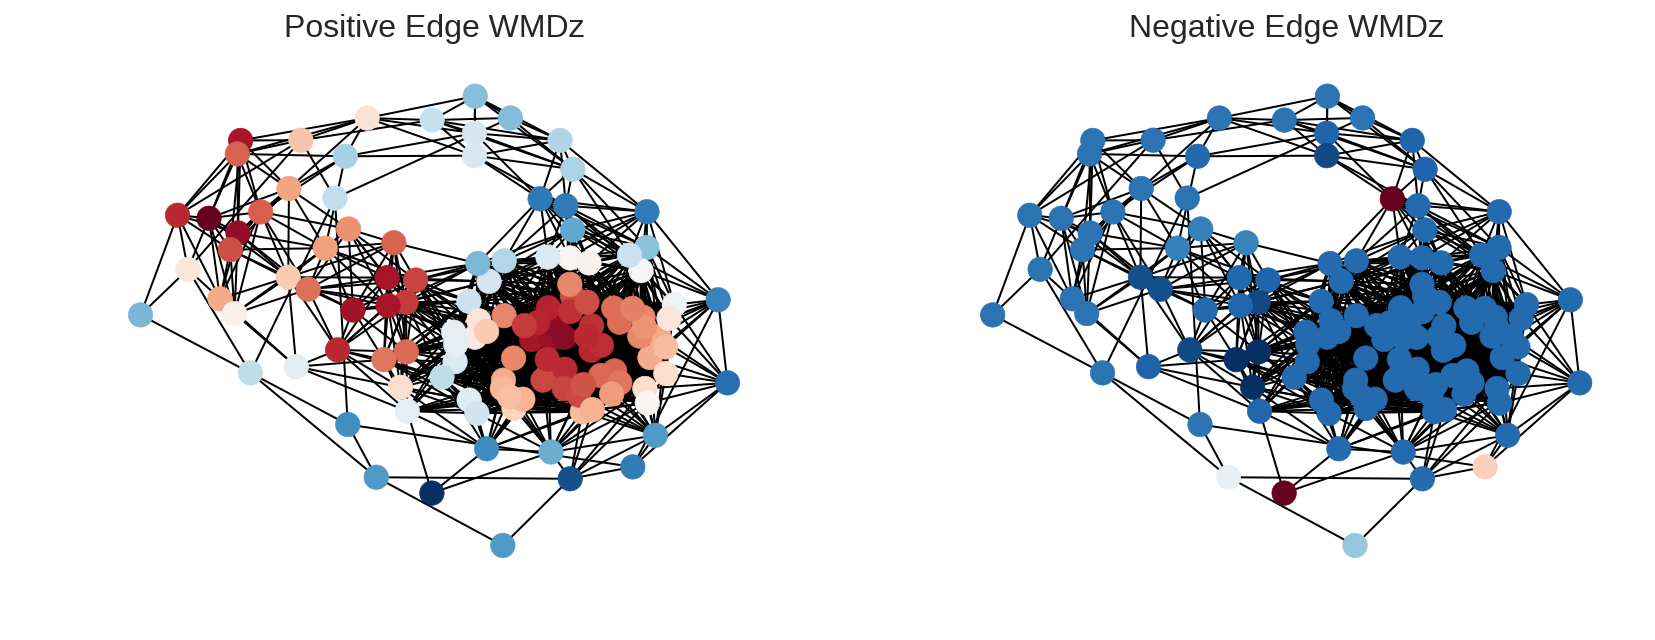

In [58]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_hac[1], node_size=150, cmap=plt.cm.RdBu_r, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_hac[2], node_size=150, cmap=plt.cm.RdBu, ax=ax[1])
g = ax[0].set_title('Positive Edge WMDz', fontsize=16)
g = ax[1].set_title('Negative Edge WMDz', fontsize=16)

Combine all our results into a single spreadsheet.

In [59]:
combined_df = pd.DataFrame(np.array([node_strength[0], node_strength[0], partition_hac_cc, pc_hac[0], pc_hac[1], wmdz_hac[1], wmdz_hac[2]]).T,
                           columns=['centrality_pos', 'centrality_neg', 'partition', 'pc_pos', 'pc_neg', 'wmdz_pos', 'wmdz_neg'])

In [60]:
combined_df = combined_df.set_index(withdrawal_mat_cc_df.index)

In [61]:
combined_df.index.names = ['Region']

Save the combined spreadsheet to disk.

In [62]:
combined_df.to_csv('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/HACPartition_combined_results.csv', sep=',')

### Impose the manually-curated partition and calculate nodal metrics.

Load the manual partition.

In [67]:
manual_partition_df = pd.read_csv('../../data/ClusterBrainListForGraphTheory.csv')

Set the index to the region labels.

In [68]:
manual_partition_df = manual_partition_df.set_index("Region")

Sort regions alphabetically.

In [69]:
manual_partition_df = manual_partition_df.sort_index()

Get an array containing module assignments for nodes in the connected component.

In [70]:
partition_manual_cc = manual_partition_df.iloc[disconnected_regions.values,2].values

Draw the graph with nodes colored by module.

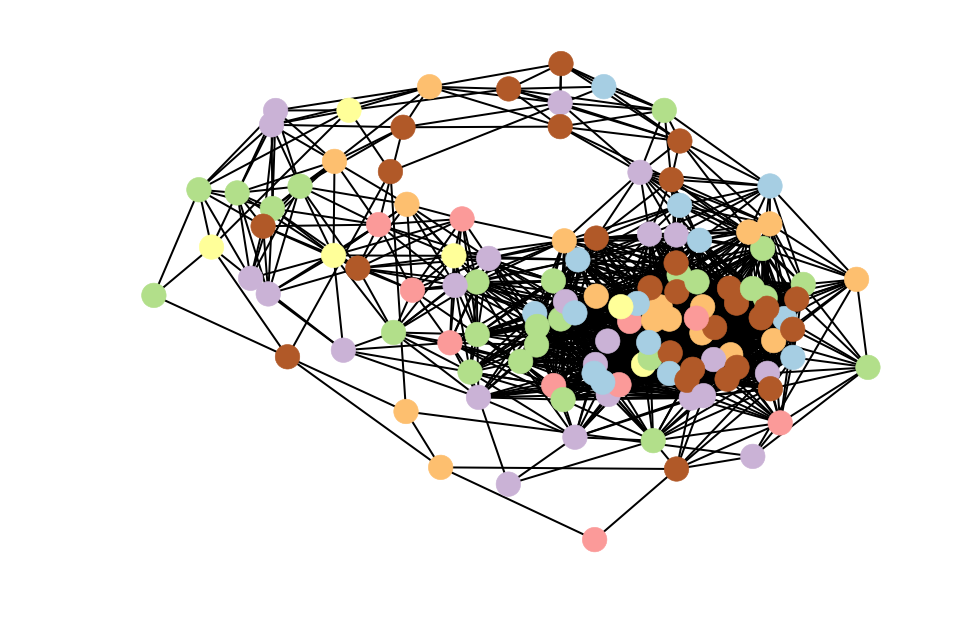

In [71]:
nx.draw_kamada_kawai(G_thresh, node_color=partition_manual_cc, node_size=150, cmap=plt.cm.Paired)

#### Participation Coefficient

In [58]:
pc_manual = bct.centrality.participation_coef_sign(withdrawal_mat_cc_df.as_matrix(), partition_manual_cc)

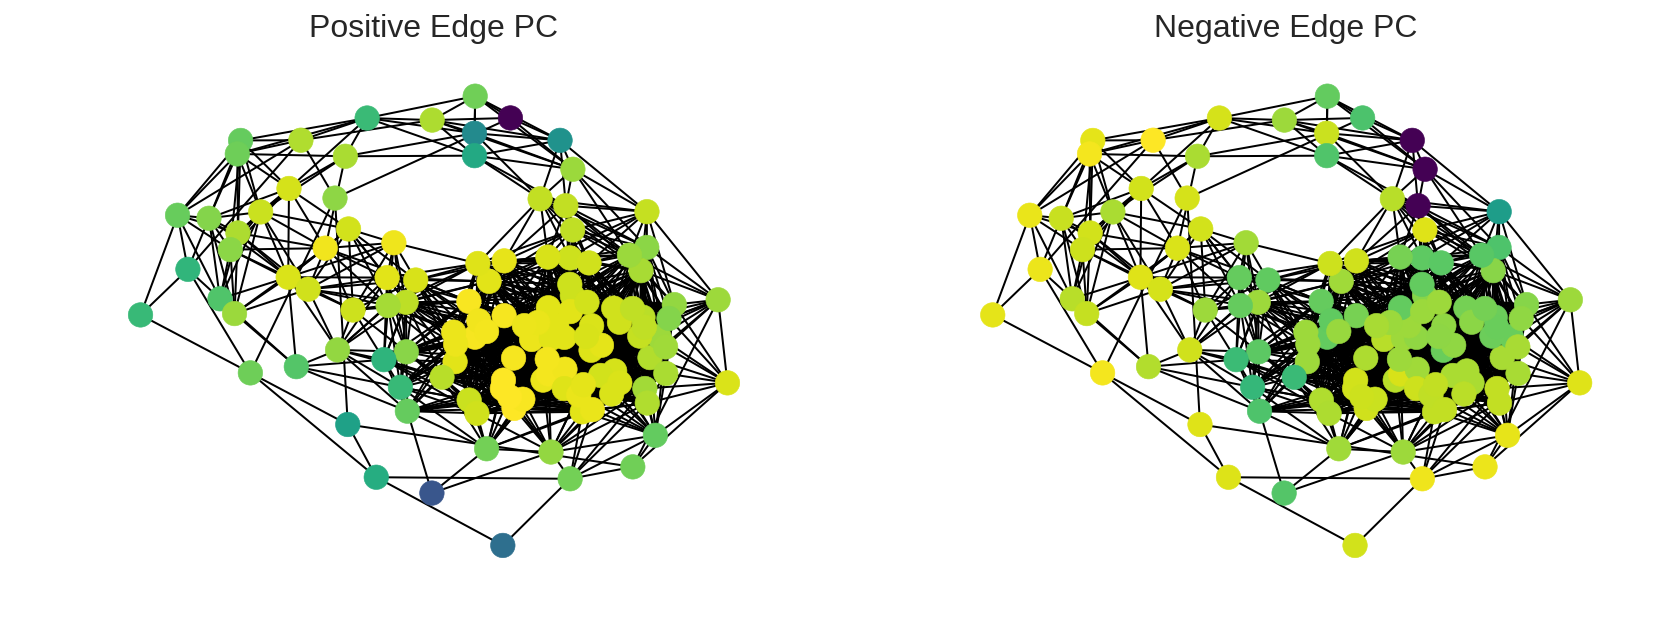

In [59]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=pc_manual[0], node_size=150, cmap=plt.cm.viridis, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=pc_manual[1], node_size=150, cmap=plt.cm.viridis, ax=ax[1])
g = ax[0].set_title('Positive Edge PC', fontsize=16)
g = ax[1].set_title('Negative Edge PC', fontsize=16)

#### Within-Module Degree (z-scored)

In [60]:
wmdz_manual = bct.centrality.module_degree_zscore_sign(withdrawal_mat_cc_df.as_matrix(), partition_manual_cc)

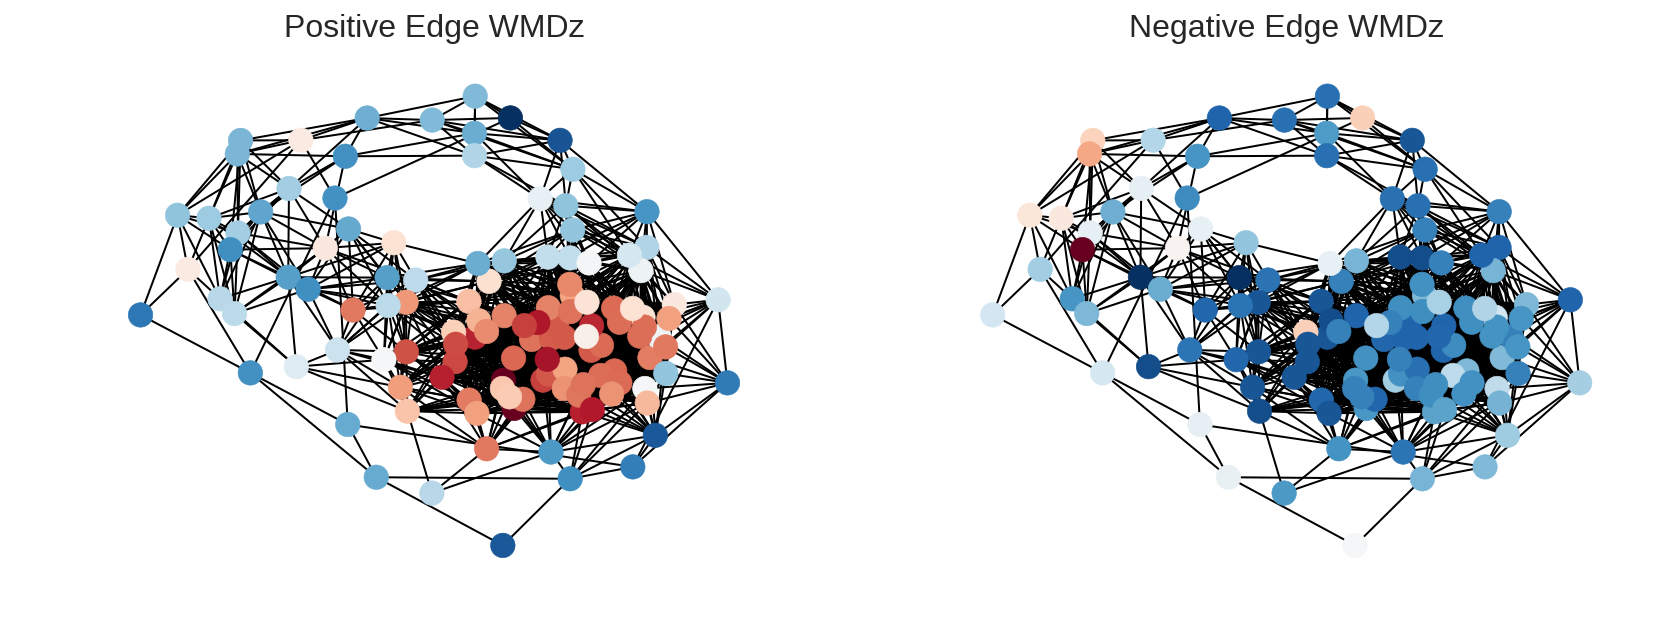

In [61]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(14,5))
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_manual[1], node_size=150, cmap=plt.cm.RdBu_r, ax=ax[0])
nx.draw_kamada_kawai(G_thresh, node_color=wmdz_manual[2], node_size=150, cmap=plt.cm.RdBu, ax=ax[1])
g = ax[0].set_title('Positive Edge WMDz', fontsize=16)
g = ax[1].set_title('Negative Edge WMDz', fontsize=16)

Combine all our results into a single spreadsheet.

In [63]:
combined_df = pd.DataFrame(np.array([node_strength[0], node_strength[0], partition_manual_cc, pc_manual[0], pc_manual[1], wmdz_manual[1], wmdz_manual[2]]).T,
                           columns=['centrality_pos', 'centrality_neg', 'partition', 'pc_pos', 'pc_neg', 'wmdz_pos', 'wmdz_neg'])

In [64]:
combined_df = combined_df.set_index(withdrawal_mat_cc_df.index)

In [65]:
combined_df.index.names = ['Region']

Save the combined spreadsheet to disk.

In [66]:
combined_df.to_csv('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_thresh075/ManualPartition_combined_results.csv', sep=',')